# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando MLP.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp
from trabalho_ic_aplicada.models.reg_perceptron import treinar_perceptron_reg, prever_perceptron_reg

2025-08-19 20:30:14.418 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


### Random Search e Avaliação Melhor Caso MLP.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from trabalho_ic_aplicada.models import reg_mlp
# import aux  # supondo que aux.calcular_metricas, etc. estejam em aux.py
import random
import itertools

def cross_val_mlp(X, y, k_fold, layer_sizes, activation, epochs, lr):
    """
    Executa CV para um MLP de 1 camada oculta, retorna média de R2 e todas as curvas de loss.
    """
    fold_r2 = []
    fold_losses = []
    for train_idx, test_idx in k_fold:
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)
        # Normaliza X
        scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
        X_tr_n = scaler.fit_transform(X_tr)
        X_te_n = scaler.transform(X_te)
        # Treina
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)
        # Previsão
        y_pred = reg_mlp.predict_mlp_regression(X_te_n, W, activation, 'linear').reshape(-1,1)
        # R2
        _, _, r2, *_ = aux.calcular_metricas(y_te, y_pred, aux)
        fold_r2.append(r2)
    return np.mean(fold_r2), fold_losses

def grid_search(X, y, k_fold, hidden_units, activations, epochs_list, lrs):
    best = {'score': -np.inf}
    for act in activations:
        for hu in hidden_units:
            for ep in epochs_list:
                for lr in lrs:
                    ls = [X.shape[1], hu, 1]
                    mean_r2, _ = cross_val_mlp(X, y, k_fold, ls, act, ep, lr)
                    print(f"Act={act:<7} HU={hu:2d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")
                    if mean_r2 > best['score']:
                        best.update({
                            'layer_sizes': ls,
                            'activation': act,
                            'epochs': ep,
                            'lr': lr,
                            'score': mean_r2
                        })
    print("\n=== Best config ===")
    print(best)
    return best



def random_search(X, y, k_fold, hidden_units, activations, epochs_list, lrs, n_iter=20, seed=42):
    """
    Executa busca aleatória por hiperparâmetros para o MLP.
    """
    random.seed(seed)
    np.random.seed(seed)

    # Gera todas as combinações possíveis
    all_combinations = list(itertools.product(activations, hidden_units, epochs_list, lrs))
    # Embaralha e pega n combinações aleatórias
    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best = {'score': -np.inf}
    for act, hu, ep, lr in sampled_combinations:
        ls = [X.shape[1], hu, 1]
        mean_r2, _ = cross_val_mlp(X, y, k_fold, ls, act, ep, lr)
        print(f"Act={act:<7} HU={hu:2d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")
        if mean_r2 > best['score']:
            best.update({
                'layer_sizes': ls,
                'activation': act,
                'epochs': ep,
                'lr': lr,
                'score': mean_r2
            })

    print("\n=== Best config ===")
    print(best)
    return best

In [4]:

# 1) Grid search
hidden_units  = [4, 8, 16, 32, 64]
activations   = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list   = [100, 200, 300]
learning_rates= [1e-3, 5e-3, 1e-2]

# 1) Random search
best_cfg = random_search(X, y, k_fold,
                         hidden_units, activations,
                         epochs_list, learning_rates,
                         n_iter=60)  # você pode ajustar n_iter

# best_cfg = grid_search(X, y, k_fold,
#                        hidden_units, activations,
#                        epochs_list, learning_rates)

Act=leaky_relu HU=32 Ep=100 LR=0.005 → R²=0.6692
Act=sigmoid HU=32 Ep=100 LR=0.005 → R²=0.6702
Act=sigmoid HU= 4 Ep=300 LR=0.001 → R²=0.6796
Act=tanh    HU=16 Ep=300 LR=0.005 → R²=0.6665
Act=tanh    HU= 8 Ep=300 LR=0.01 → R²=0.6626
Act=tanh    HU= 8 Ep=200 LR=0.001 → R²=0.6682
Act=sigmoid HU=32 Ep=300 LR=0.01 → R²=0.6750
Act=sigmoid HU=16 Ep=300 LR=0.01 → R²=0.6697
Act=leaky_relu HU= 4 Ep=200 LR=0.005 → R²=0.6063
Act=sigmoid HU=16 Ep=200 LR=0.005 → R²=0.6796
Act=leaky_relu HU= 8 Ep=300 LR=0.005 → R²=0.6410
Act=relu    HU=16 Ep=100 LR=0.001 → R²=0.6475
Act=sigmoid HU= 4 Ep=300 LR=0.01 → R²=0.6526
Act=sigmoid HU= 4 Ep=300 LR=0.005 → R²=0.6715
Act=sigmoid HU=16 Ep=200 LR=0.01 → R²=0.6715
Act=tanh    HU= 8 Ep=100 LR=0.005 → R²=0.6565
Act=tanh    HU= 8 Ep=200 LR=0.01 → R²=0.6727
Act=relu    HU=64 Ep=200 LR=0.001 → R²=0.6699
Act=leaky_relu HU=16 Ep=100 LR=0.005 → R²=0.6620
Act=leaky_relu HU=64 Ep=300 LR=0.001 → R²=0.6745
Act=leaky_relu HU= 4 Ep=300 LR=0.01 → R²=0.6698
Act=tanh    HU= 4 Ep=20


=== Best config ===
{'score': np.float64(0.6907358683810801), 'layer_sizes': [5, 64, 1], 'activation': 'leaky_relu', 'epochs': 300, 'lr': 0.001}

Erro Quadrático Médio (EQM): 62.3935 ± 39.7526
Raiz do Erro Quadrático Médio (REQM): 7.5952 ± 2.1694
Hit rate 20%: 0.7951 ± 0.0537
Hit rate 10%: 0.4810 ± 0.0713

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8420 ± 0.0113
Correlação Média (Teste): 0.8314 ± 0.0642
Coeficiente de Determinação (R²): 0.6770 ± 0.1045

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8225, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8336, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


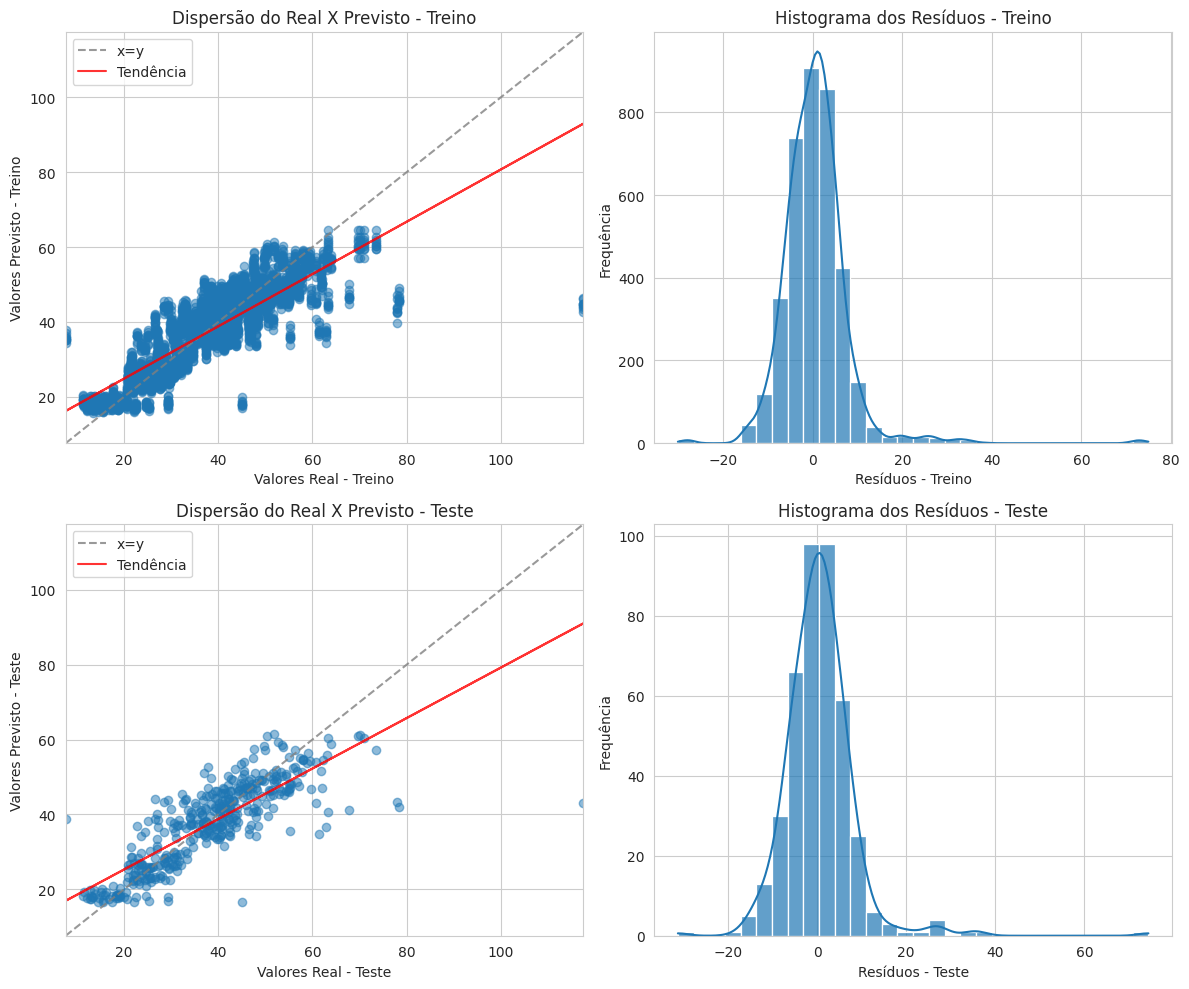

Avg. house price: 37.4114 ± 11.2435
RSME/Avg. house price: 0.1435 ± 0.1696


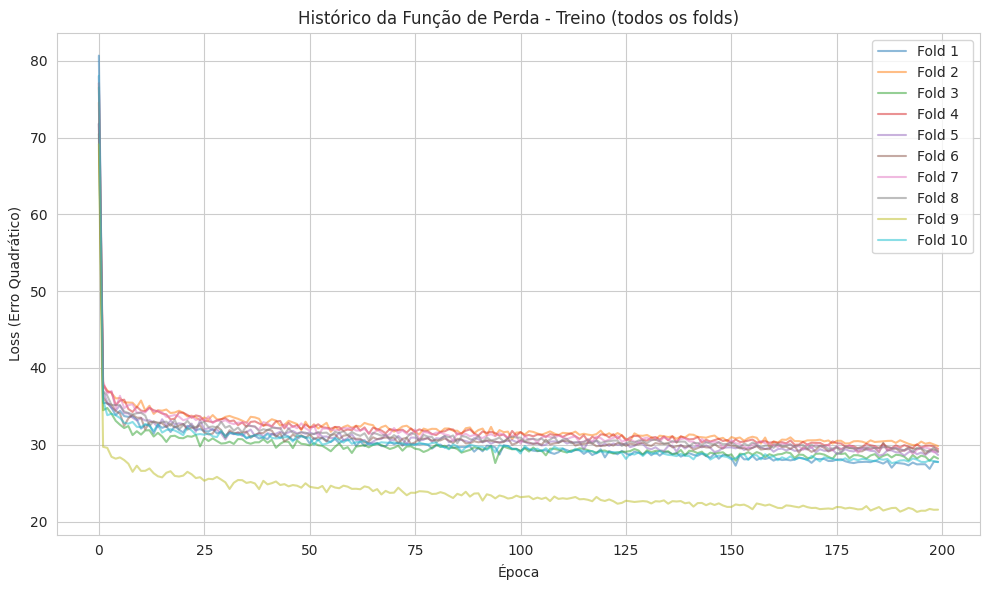

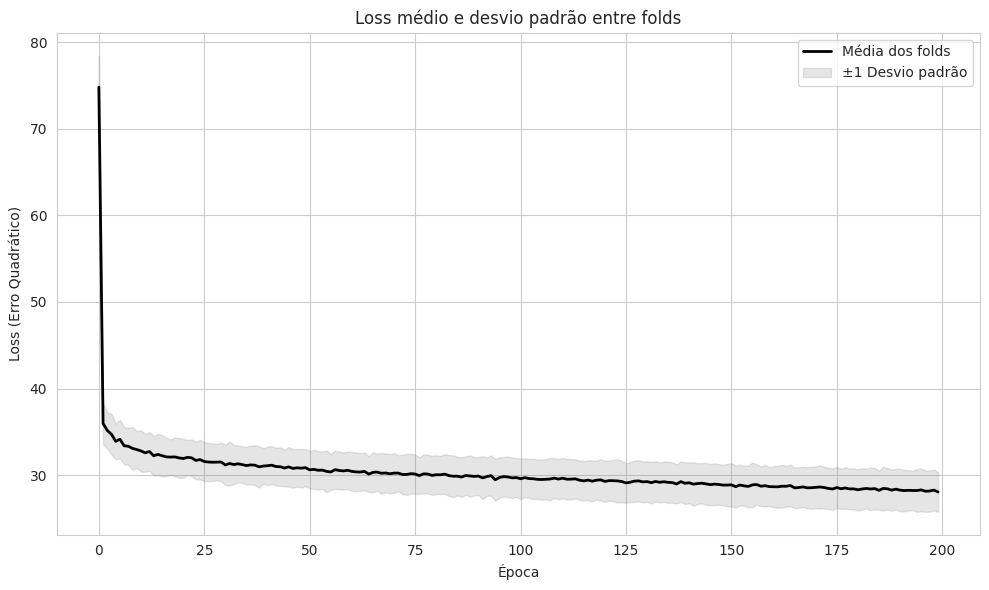

In [6]:

y_tests = []            # y verdadeiro (teste, todos folds)
y_test_preds = []       # y predito (teste, todos folds)

# 2) Treino final com CV para coletar tudo
ls   = best_cfg['layer_sizes']
act  = best_cfg['activation']
ep   = best_cfg['epochs']
lr   = best_cfg['lr']

all_train_losses = []
y_tr_all, y_trp_all = [], []
y_te_all, y_tep_all   = [], []
cor_tr, cor_te = [], []

eqms, reqms, r2s, h20, h10 = [], [], [], [], []


for train_idx, test_idx in k_fold:
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)
    scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
    X_tr_n = scaler.fit_transform(X_tr)
    X_te_n = scaler.transform(X_te)

    W, loss_hist = reg_mlp.train_mlp_regression(
        X_tr_n, y_tr, layer_sizes=ls,
        epochs=ep, eta_i=lr, eta_f=lr,
        hidden_activation=act, output_activation='linear',
        verbose=False
    )
    all_train_losses.append(loss_hist)

    y_trp = reg_mlp.predict_mlp_regression(X_tr_n, W, act, 'linear').reshape(-1,1)
    y_tep = reg_mlp.predict_mlp_regression(X_te_n, W, act, 'linear').reshape(-1,1)

    cor_tr.append(np.corrcoef(y_tr.flatten(), y_trp.flatten())[0,1])
    cor_te.append(np.corrcoef(y_te.flatten(), y_tep.flatten())[0,1])

    eqm, reqm, r2, hit_20, hit_10, _ = aux.calcular_metricas(y_te, y_tep, aux)
    eqms.append(eqm)
    reqms.append(reqm)
    r2s.append(r2)
    h20.append(hit_20)
    h10.append(hit_10)


    y_tr_all .extend(y_tr.flatten())
    y_trp_all.extend(y_trp.flatten())
    y_te_all .extend(y_te.flatten())
    y_tep_all.extend(y_tep.flatten())

# 3) Métricas finais
aux.imprimir_metricas(eqms, reqms, r2s, h20, h10)
aux.imprimir_correlacoes(cor_tr, cor_te, r2s)
aux.analisar_residuos(
    np.array(y_tr_all), np.array(y_trp_all),
    np.array(y_te_all), np.array(y_tep_all),
    aux, titulo="MLP Final"
)

aux.calcular_metricas_normalizadas(y_tep_all, y_te_all)

# 4) Plots de loss
aux.plot_folds_loss(all_train_losses)


In [8]:
### Random Search (com normalizações) e avaliação final em hold-out
import itertools, random, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

# -------------------------------
# Hold-out: treino/teste (fixo)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# K-fold APENAS no treino (k=5)
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=5)

# Espaço de busca
hidden_units = [4, 8, 16, 32, 64]
activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list = [100, 200, 300]
learning_rates = [1e-3, 5e-3, 1e-2]
norm_options = ['none', 'zscore', 'minmax', 'iqr']  # NOVO


def make_scaler(name: str, n_samples: int):
    if name == 'none':
        class _NoOp:
            def fit(self, X): return self

            def transform(self, X): return X

            def fit_transform(self, X): return X

        return _NoOp()
    if name == 'zscore':
        return StandardScaler()
    if name == 'minmax':
        return MinMaxScaler()
    if name == 'iqr':
        return QuantileTransformer(
            n_quantiles=min(n_samples, 1000),
            output_distribution='uniform',
            random_state=42
        )
    raise ValueError(f"Normalização desconhecida: {name}")


def cross_val_mlp(X_in, y_in, kfold, layer_sizes, activation, epochs, lr, norm_name):
    """
    CV no TREINO para um MLP (1 camada oculta), com normalização variável em X.
    Saída linear; y não é normalizado.
    Retorna R² médio e histórico de losses por fold.
    """
    fold_r2, fold_losses = [], []
    for tr_idx, va_idx in kfold:
        X_tr, X_va = X_in[tr_idx], X_in[va_idx]
        y_tr, y_va = y_in[tr_idx].reshape(-1, 1), y_in[va_idx].reshape(-1, 1)

        scaler_X = make_scaler(norm_name, X_tr.shape[0])
        X_tr_n = scaler_X.fit_transform(X_tr)
        X_va_n = scaler_X.transform(X_va)

        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)

        y_va_pred = reg_mlp.predict_mlp_regression(
            X_va_n, W, activation, 'linear'
        ).reshape(-1, 1)

        _, _, r2, *_ = aux.calcular_metricas(y_va, y_va_pred, aux)
        fold_r2.append(r2)

    return float(np.mean(fold_r2)), fold_losses


def random_search_with_norm(
        X_in, y_in, kfold,
        hidden_units, activations, epochs_list, lrs, norm_options,
        n_iter=60, seed=42
):
    """
    Random Search incluindo normalizações. Mostra progresso e best-so-far.
    """
    random.seed(seed);
    np.random.seed(seed)

    all_combos = list(itertools.product(norm_options, activations, hidden_units, epochs_list, lrs))
    sampled = random.sample(all_combos, min(n_iter, len(all_combos)))
    total = len(sampled)

    results = []  # histórico completo para ranking
    best = {'score': -np.inf}
    t0 = time.time()

    for i, (norm_name, act, hu, ep, lr) in enumerate(sampled, start=1):
        ls = [X_in.shape[1], hu, 1]
        mean_r2, _ = cross_val_mlp(X_in, y_in, kfold, ls, act, ep, lr, norm_name)

        results.append({
            'norm': norm_name, 'activation': act, 'hu': hu,
            'epochs': ep, 'lr': lr, 'r2_val_mean': mean_r2
        })

        if mean_r2 > best['score']:
            best.update({
                'norm': norm_name, 'activation': act, 'layer_sizes': ls,
                'epochs': ep, 'lr': lr, 'score': mean_r2
            })

        # Progresso
        elapsed = time.time() - t0
        print(f"[{i}/{total}] norm={norm_name:<6} act={act:<10} HU={hu:>2} Ep={ep:>3} LR={lr:<.3g} "
              f"→ R²cv={mean_r2:.4f} | best={best['score']:.4f} ({best['norm']},{best['activation']},HU={best['layer_sizes'][1]}) "
              f"| {elapsed:.1f}s")

    # Ordena top-N
    results_sorted = sorted(results, key=lambda d: -d['r2_val_mean'])
    print("\n=== TOP-10 (CV no TREINO) ===")
    for row in results_sorted[:10]:
        print(f"{row['norm']:>6} | {row['activation']:<10} | HU={row['hu']:>2} | Ep={row['epochs']:>3} | "
              f"LR={row['lr']:<.3g} | R²={row['r2_val_mean']:.4f}")

    print("\n=== Melhor configuração (CV no TREINO) ===")
    print(best)
    return best, results_sorted


# -------------------------------
# Executa Random Search no TREINO
# -------------------------------
best_cfg, cv_rank = random_search_with_norm(
    X_train, y_train, k_fold_train,
    hidden_units, activations, epochs_list, learning_rates, norm_options,
    n_iter=50, seed=42
)

# -------------------------------
# Reajuste no TREINO COMPLETO e avaliação no TESTE (hold-out)
# -------------------------------
norm_best = best_cfg['norm']
act_best = best_cfg['activation']
ls_best = best_cfg['layer_sizes']
ep_best = best_cfg['epochs']
lr_best = best_cfg['lr']

# Scaler final (treino completo)
scaler_X_final = make_scaler(norm_best, X_train.shape[0])
X_train_n = scaler_X_final.fit_transform(X_train)
X_test_n = scaler_X_final.transform(X_test)

# Treino final
W_best, loss_hist_best = reg_mlp.train_mlp_regression(
    X_train_n, y_train.reshape(-1, 1),
    layer_sizes=ls_best,
    epochs=ep_best,
    eta_i=lr_best, eta_f=lr_best,
    hidden_activation=act_best,
    output_activation='linear',
    verbose=False
)

# Predições
y_train_pred = reg_mlp.predict_mlp_regression(X_train_n, W_best, act_best, 'linear').reshape(-1, 1)
y_test_pred = reg_mlp.predict_mlp_regression(X_test_n, W_best, act_best, 'linear').reshape(-1, 1)

# Métricas no hold-out
eqm_t, rmse_t, r2_t, hit20_t, hit10_t, _ = aux.calcular_metricas(y_test.reshape(-1, 1), y_test_pred, aux)
print("\n=== DESEMPENHO NO TESTE (HOLD-OUT) ===")
print(f"R² = {r2_t:.4f} | RMSE = {rmse_t:.4f} | EQM = {eqm_t:.4f} | "
      f"Hit@10 = {hit10_t:.4f} | Hit@20 = {hit20_t:.4f}")

# -------------------------------
# Resíduos apenas no hold-out
# -------------------------------
corr_tr = np.corrcoef(y_train, y_train_pred.flatten())[0, 1]
corr_te = np.corrcoef(y_test, y_test_pred.flatten())[0, 1]
aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_t])

aux.analisar_residuos(
    y_train, y_train_pred.flatten(),
    y_test, y_test_pred.flatten(),
    aux,
    titulo="MLP (linear) — hold-out"
)

aux.calcular_metricas_normalizadas(y_test_pred.flatten(), y_test)

# Curva de perda do treino final
aux.plot_folds_loss(
    [loss_hist_best],
    titulo="Loss (treino final) — MLP",
    ylabel="Erro Quadrático",
    xlabel="Época"
)


[1/60] norm=iqr    act=relu       HU=16 Ep=300 LR=0.001 → R²cv=0.6602 | best=0.6602 (iqr,relu,HU=16) | 26.8s
[2/60] norm=none   act=relu       HU=16 Ep=300 LR=0.001 → R²cv=-0.0113 | best=0.6602 (iqr,relu,HU=16) | 54.3s
[3/60] norm=none   act=sigmoid    HU=16 Ep=300 LR=0.005 → R²cv=-0.0322 | best=0.6602 (iqr,relu,HU=16) | 83.7s


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:195: RuntimeWarning: invalid value encountered in multiply
  delta = error_prev * hidden_deriv(activations[i])
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_i

[4/60] norm=zscore act=relu       HU= 8 Ep=100 LR=0.01 → R²cv=nan | best=0.6602 (iqr,relu,HU=16) | 93.1s
[5/60] norm=zscore act=tanh       HU=16 Ep=300 LR=0.005 → R²cv=0.6119 | best=0.6602 (iqr,relu,HU=16) | 118.4s
[6/60] norm=zscore act=tanh       HU= 4 Ep=200 LR=0.001 → R²cv=0.6053 | best=0.6602 (iqr,relu,HU=16) | 133.1s


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/

[7/60] norm=none   act=leaky_relu HU= 4 Ep=300 LR=0.005 → R²cv=nan | best=0.6602 (iqr,relu,HU=16) | 159.2s
[8/60] norm=none   act=relu       HU= 8 Ep=200 LR=0.01 → R²cv=-0.0106 | best=0.6602 (iqr,relu,HU=16) | 178.8s
[9/60] norm=iqr    act=leaky_relu HU= 8 Ep=300 LR=0.01 → R²cv=0.6148 | best=0.6602 (iqr,relu,HU=16) | 212.5s
[10/60] norm=iqr    act=sigmoid    HU=16 Ep=100 LR=0.001 → R²cv=0.6647 | best=0.6647 (iqr,sigmoid,HU=16) | 231.0s
[11/60] norm=none   act=tanh       HU=64 Ep=300 LR=0.01 → R²cv=-0.7288 | best=0.6647 (iqr,sigmoid,HU=16) | 270.1s
[12/60] norm=iqr    act=tanh       HU=16 Ep=100 LR=0.005 → R²cv=0.6572 | best=0.6647 (iqr,sigmoid,HU=16) | 281.5s
[13/60] norm=minmax act=tanh       HU=32 Ep=100 LR=0.001 → R²cv=0.6469 | best=0.6647 (iqr,sigmoid,HU=16) | 292.8s
[14/60] norm=none   act=sigmoid    HU=32 Ep=200 LR=0.01 → R²cv=-0.2544 | best=0.6647 (iqr,sigmoid,HU=16) | 318.8s
[15/60] norm=none   act=sigmoid    HU=32 Ep=200 LR=0.001 → R²cv=-0.0517 | best=0.6647 (iqr,sigmoid,HU=16

KeyboardInterrupt: 